In [2]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import torch
import torch.optim as optim
from torch.optim import Adam

from nflows.flows import MaskedAutoregressiveFlow
from matplotlib import cm, ticker
from numpy import ma

# Plot functions

In [1]:
from counterfactuals.utils import plot_x_point, plot_distributions

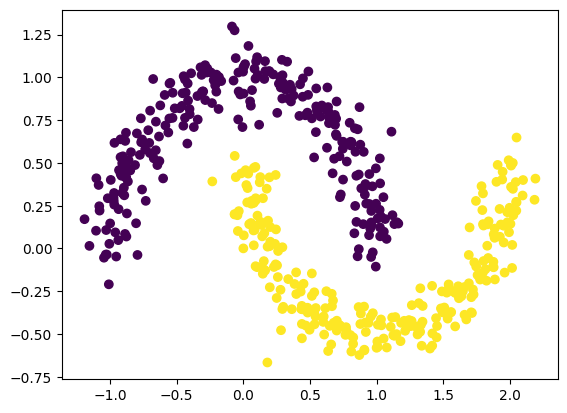

In [3]:
x, y = datasets.make_moons(512, noise=0.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [4]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
optimizer = optim.Adam(flow.parameters())

In [5]:
num_iter = 10000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    if (i + 1) % 1000 == 0:
        print(loss.item())

0.42699021100997925
0.5077304244041443
0.4736311733722687
0.36331823468208313
0.27158769965171814
0.392343133687973
0.40145343542099
0.334448903799057
0.2879040539264679
0.3561641275882721


# Approach 1

$$ argmin \quad d(x, x’) - log p(x’|y’)$$
$$ log p(x’|y’) = log p(y’|x’)*p(x') $$

In [9]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0):
    model.eval()
    # y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)
    p_hat = model.log_prob(x, context=y_hat) #.exp()
    dist = torch.linalg.norm(x_origin-x, axis=1)
    return dist - p_hat

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


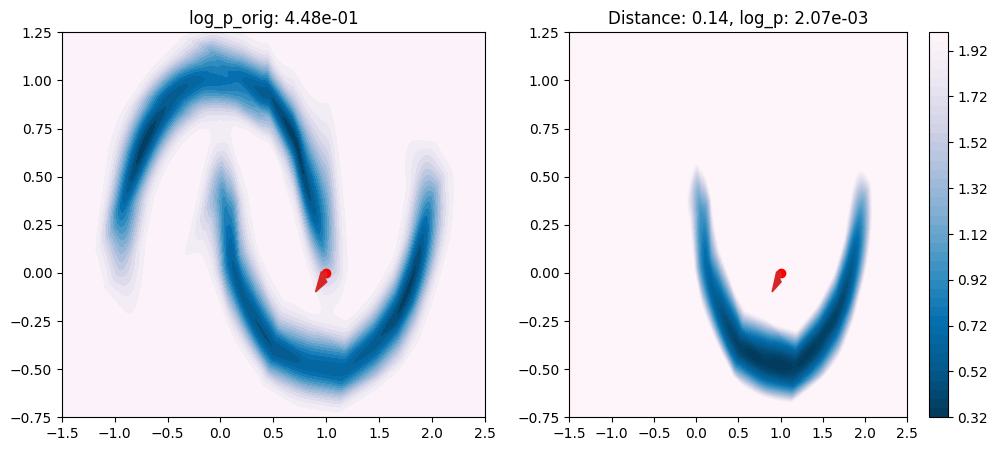

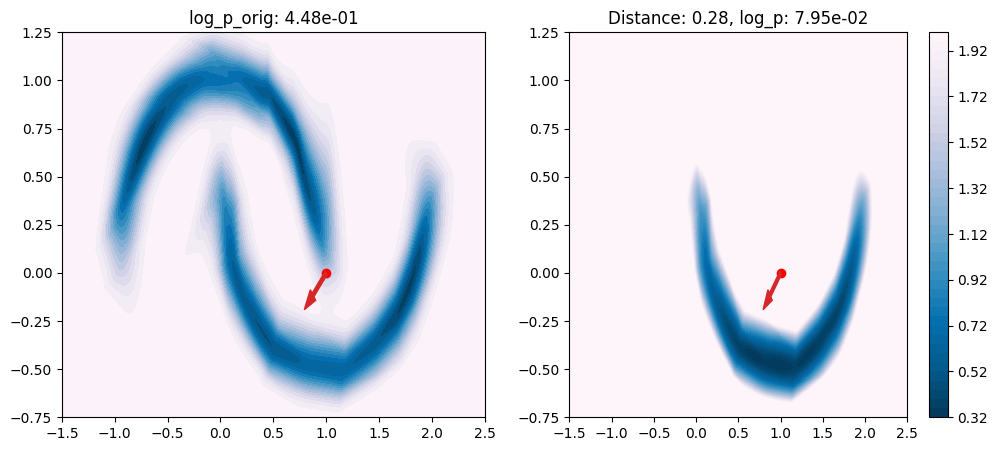

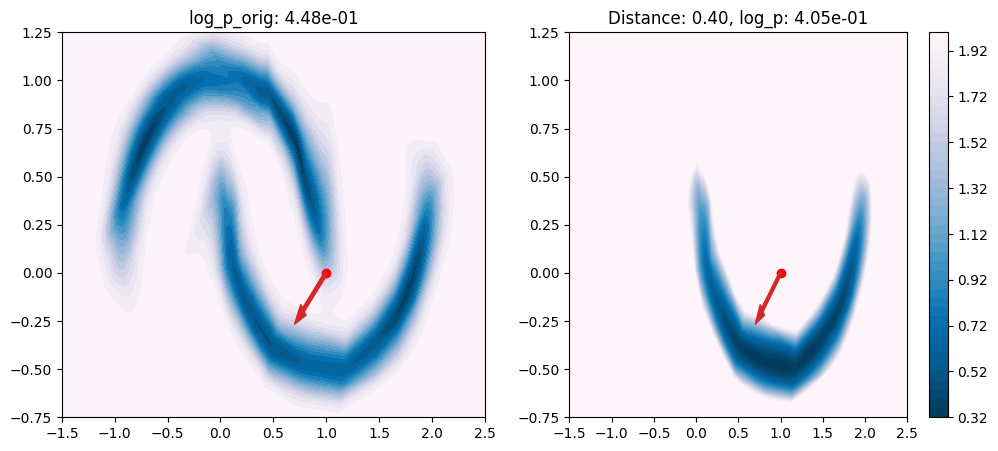

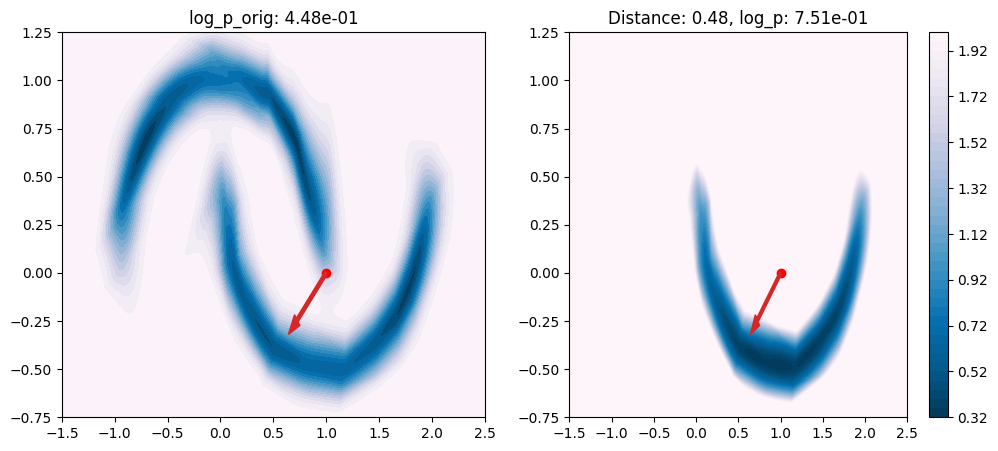

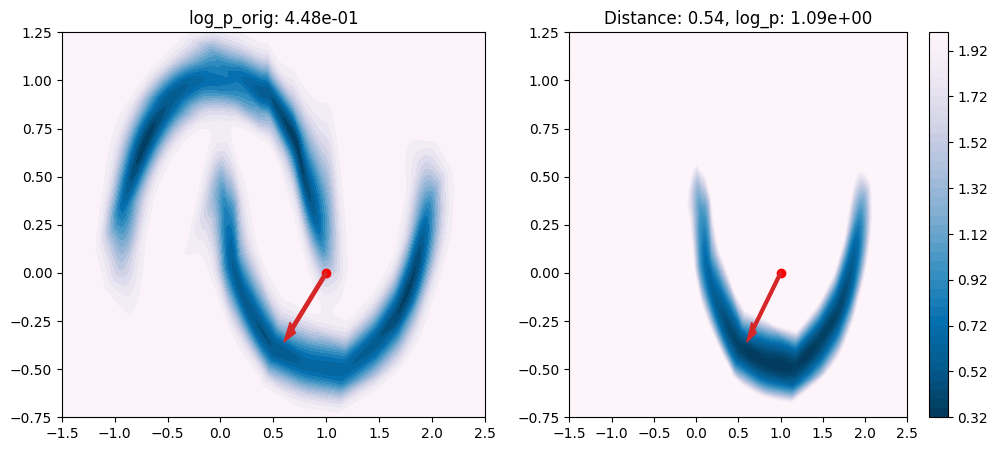

In [10]:
optimizer = Adam([x], lr=0.01)

num_iterations = 50
for i in range(num_iterations):
    flow.train()
    y = optim_function(x, x_origin, flow, alpha=100)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=100)

# Approach 2

$$agmin\quad d(x, x’) - \lambda (log p(x’|y’) - log(p(x’|y) + p(x’|y')))$$

In [28]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0):
    model.eval()

    y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)

    dist = torch.linalg.norm(x_origin-x, axis=1)
    
    p_orig = model.log_prob(x, context=y_orig)
    p_hat = model.log_prob(x, context=y_hat)
    
    return dist - alpha * (p_hat - torch.logsumexp(torch.concat([p_orig, p_hat]), dim=0))

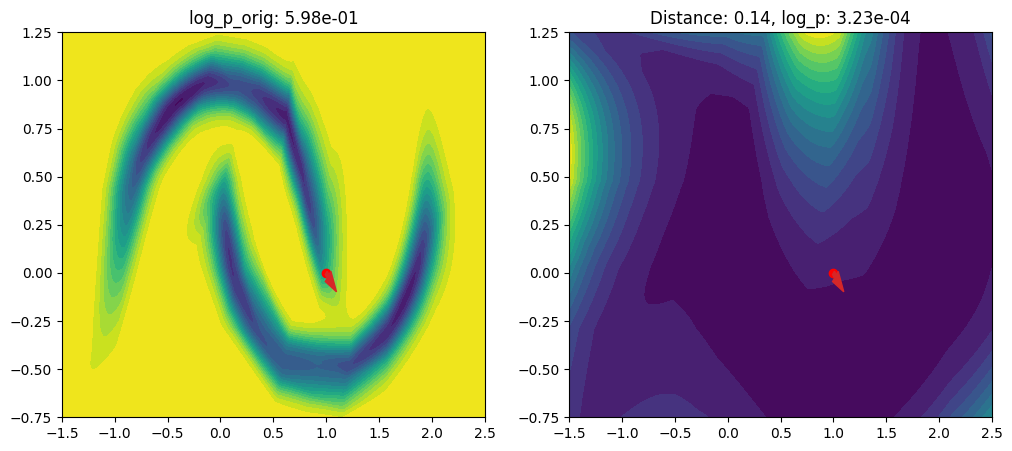

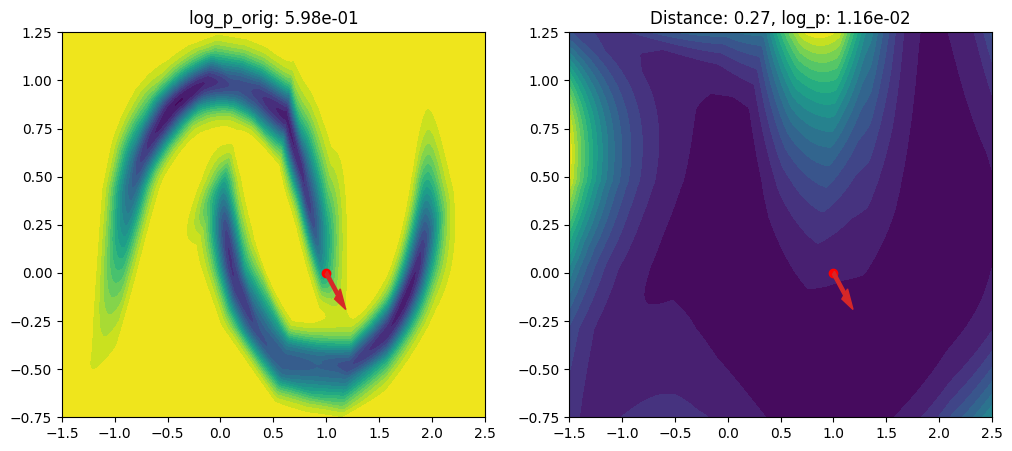

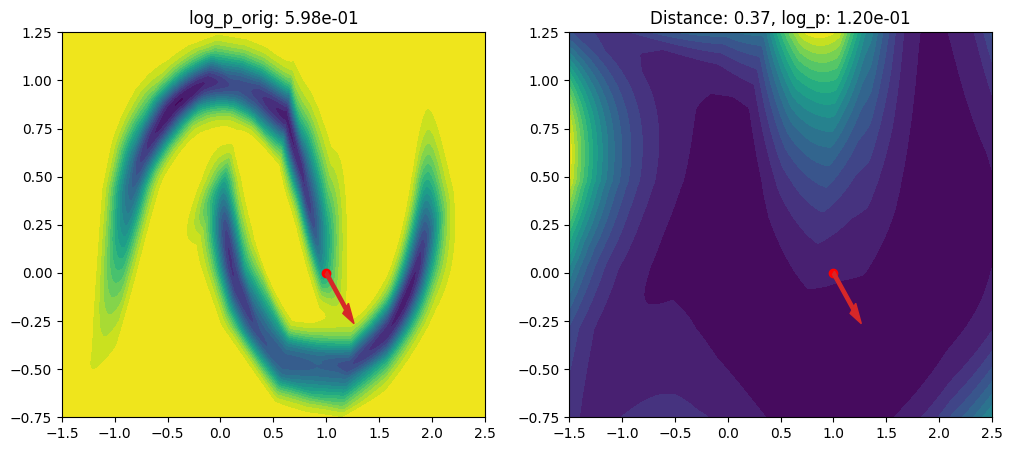

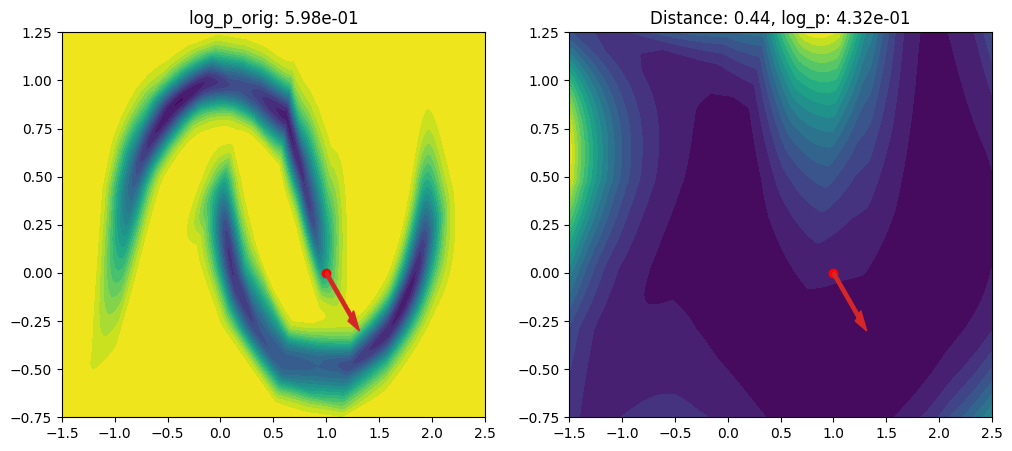

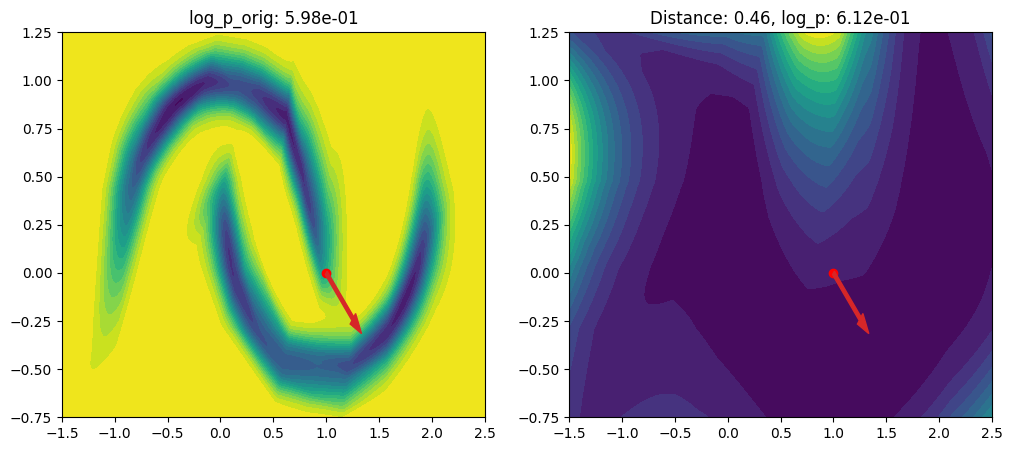

In [29]:
optimizer = Adam([x], lr=0.01)
alpha = 1

num_iterations = 50
for i in range(num_iterations):
    flow.train()
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        # plot_x_point(x, x_origin, flow)
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)

# Approach 3

$$ \beta = 0.01 $$
$$\theta = \beta + p(x'|y) - p(x'|y') $$
$$agmin\quad d(x, x’) + \alpha*max(\theta, 0)$$

In [8]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=20.0, beta=0.01):
    model.eval()
    dist = torch.linalg.norm(x_origin-x, axis=1)

    y_orig = torch.zeros(x.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)

    p_orig = model.log_prob(x, context=y_orig).exp()
    p_hat = model.log_prob(x, context=y_hat).exp()
    theta = (p_orig - p_hat + beta)
    max_theta = torch.clamp(theta, min=0)
    loss = alpha * max_theta + dist
    return loss

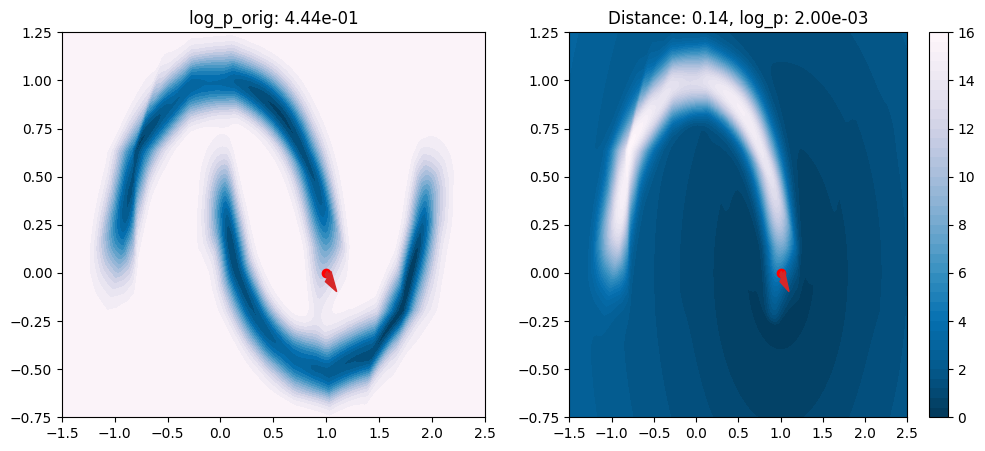

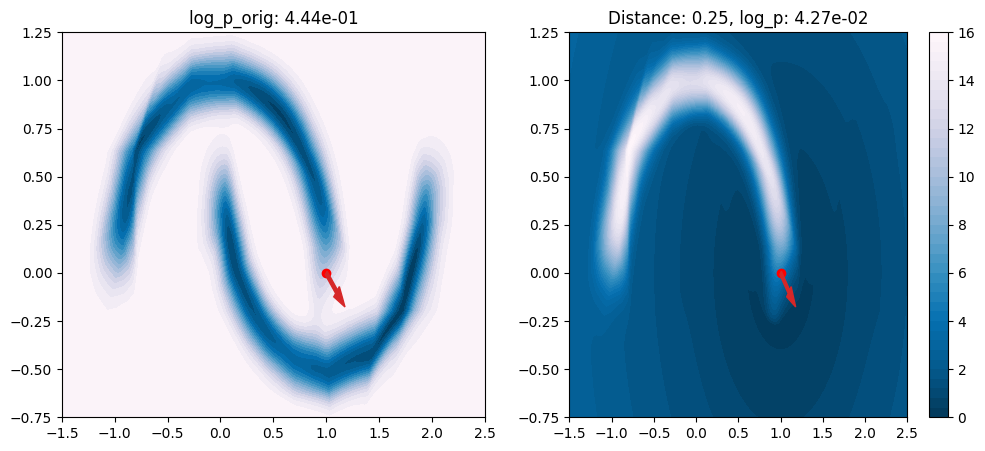

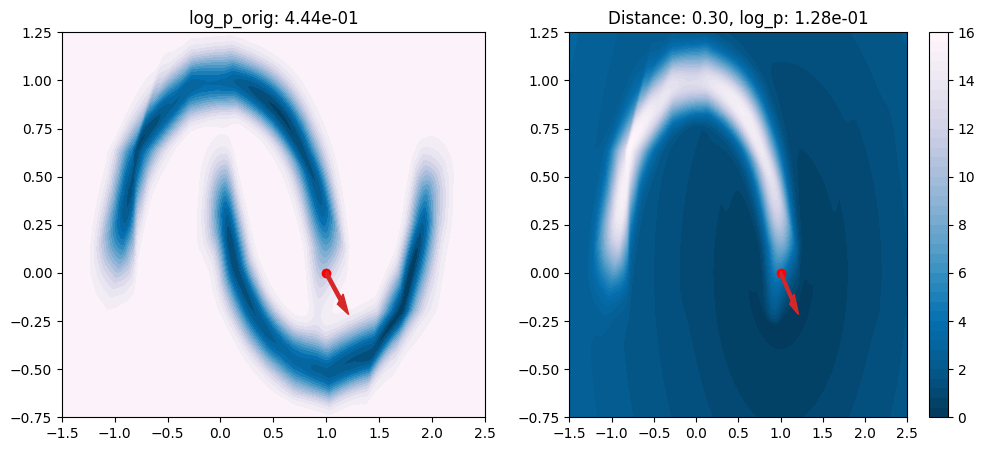

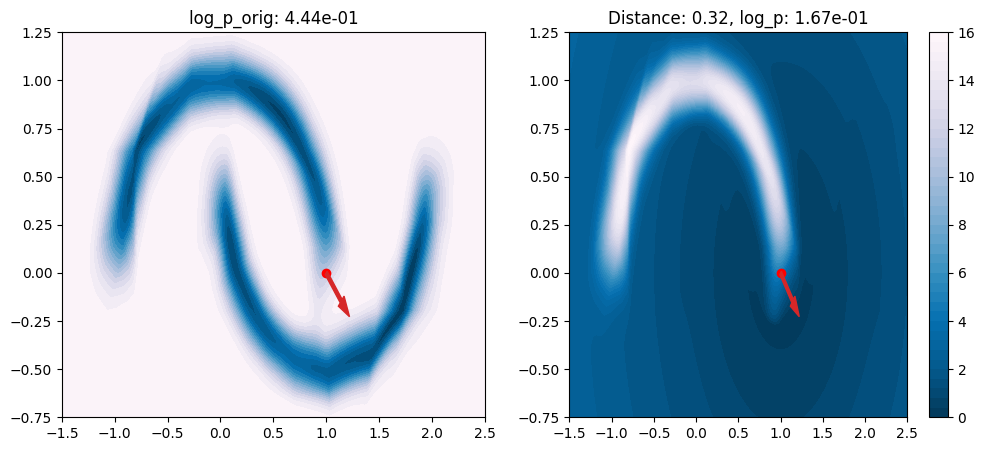

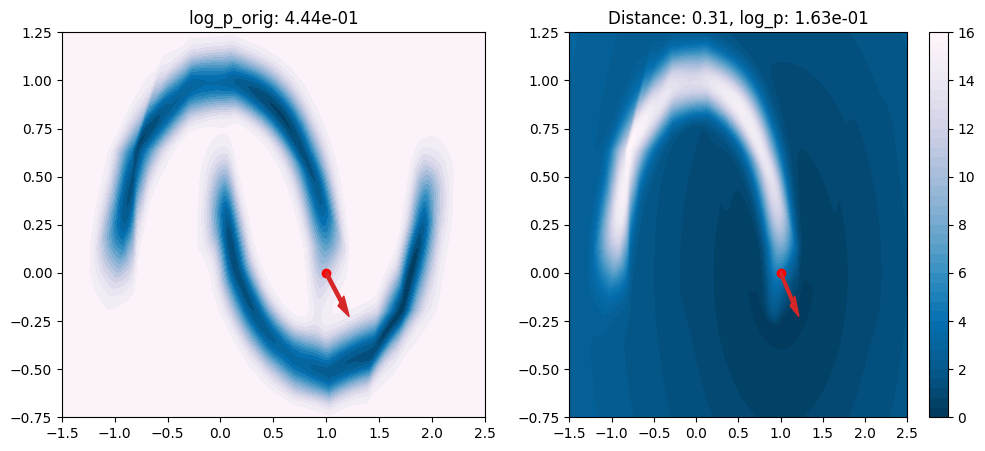

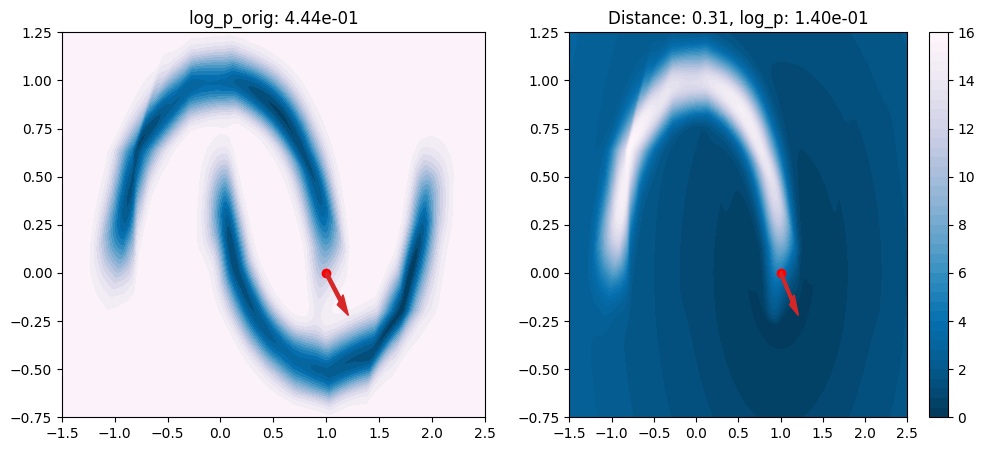

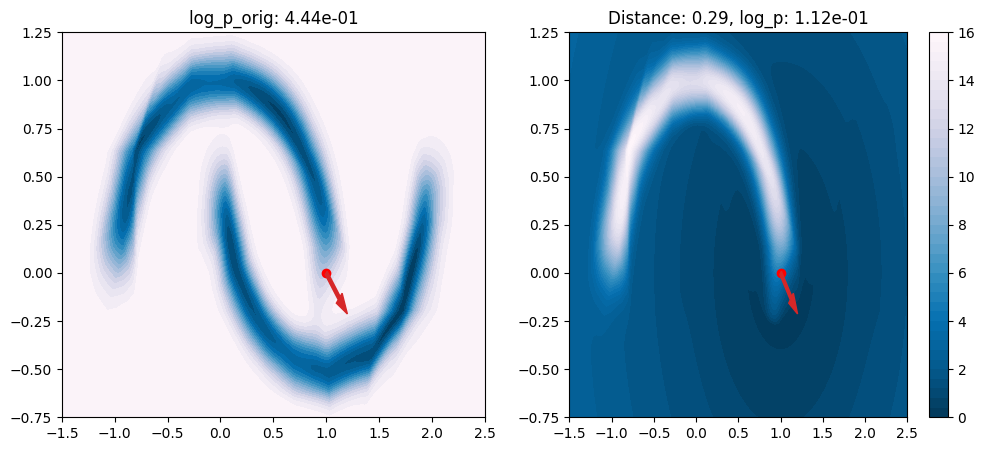

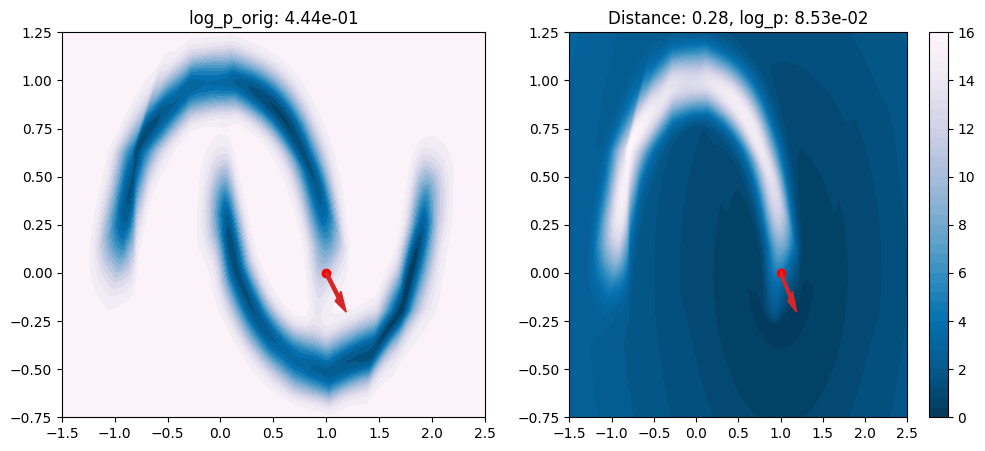

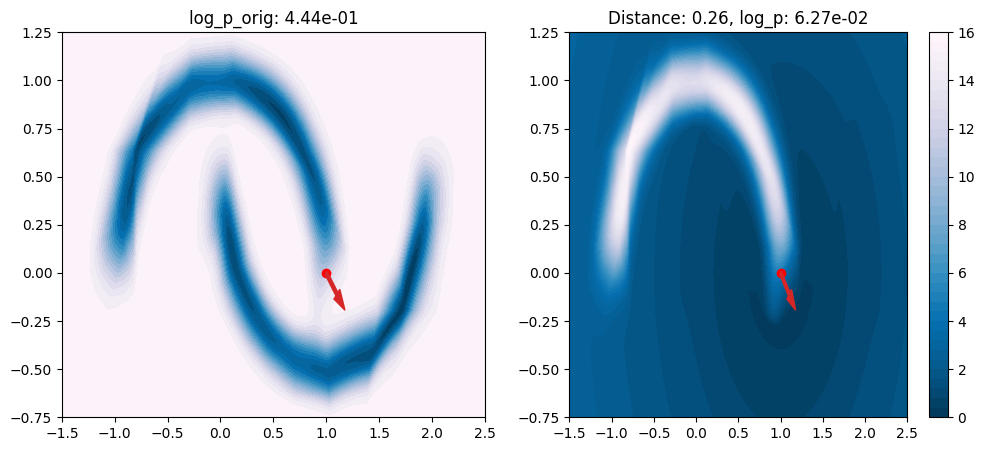

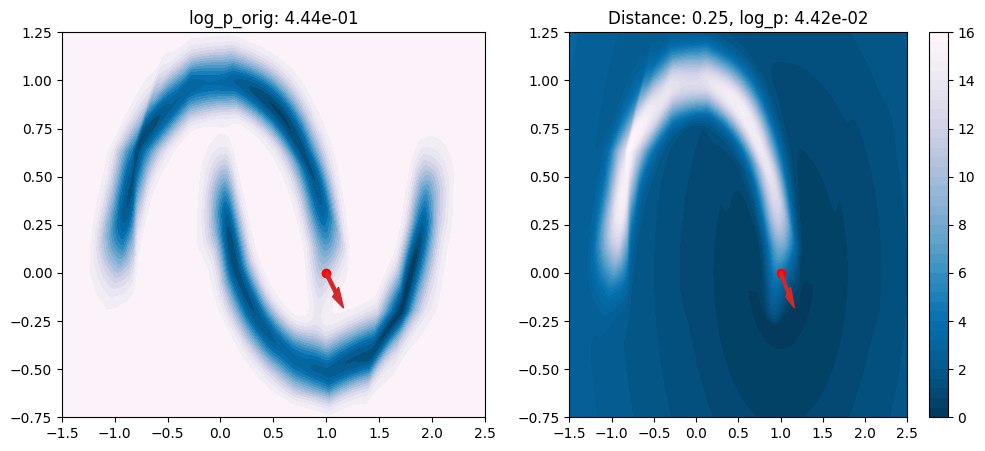

In [9]:
optimizer = Adam([x], lr=0.01)
alpha = 10

num_iterations = 100
for i in range(num_iterations):
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)

# Approach 4
$$ \alpha = 0.001 $$
$$agmin\quad \alpha * d(x, x’) + |p(x'|y') - p(x|y)|$$

In [10]:
x_origin = torch.tensor([[1.,  0.]], requires_grad=False)
x = torch.tensor([[1.,  0.]], requires_grad=True)

def optim_function(x, x_origin, model, alpha=1.0):
    model.eval()
    y_orig = torch.zeros(x_origin.shape[0]).reshape(-1, 1)
    y_hat = torch.ones(x.shape[0]).reshape(-1, 1)
    p_orig = model.log_prob(x_origin, context=y_orig).exp()
    p_hat = model.log_prob(x, context=y_hat).exp()
    theta = torch.abs(p_orig - p_hat)
    dist = torch.linalg.norm(x_origin-x, axis=1)
    return alpha * dist + theta

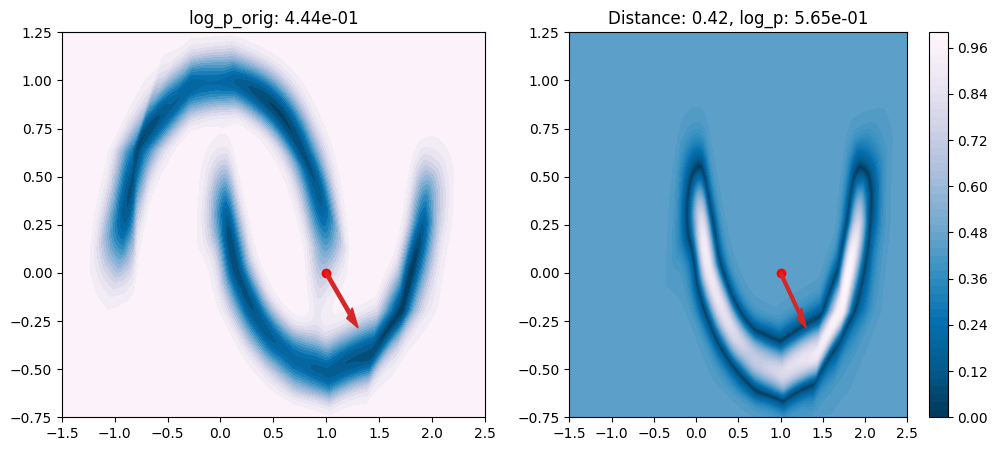

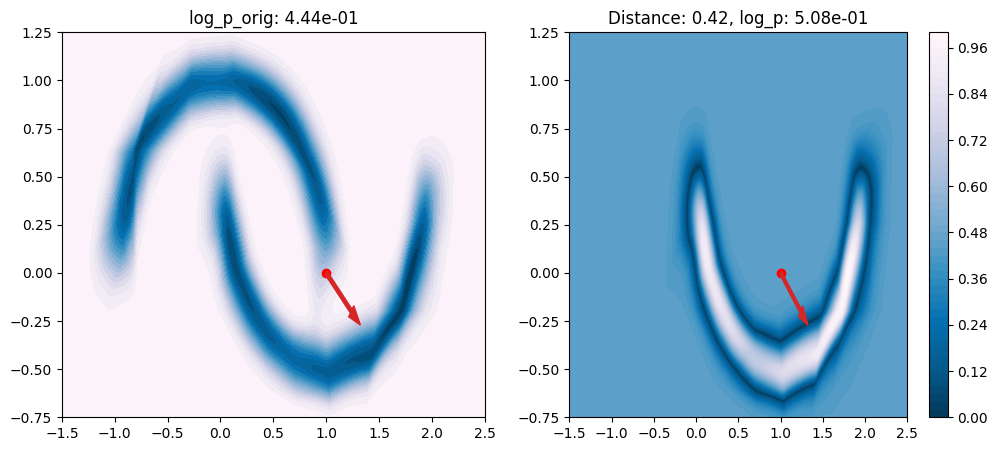

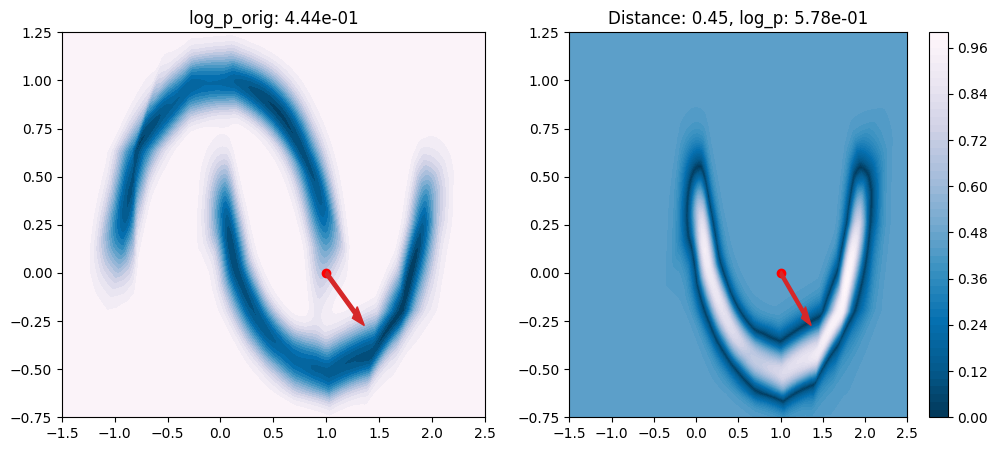

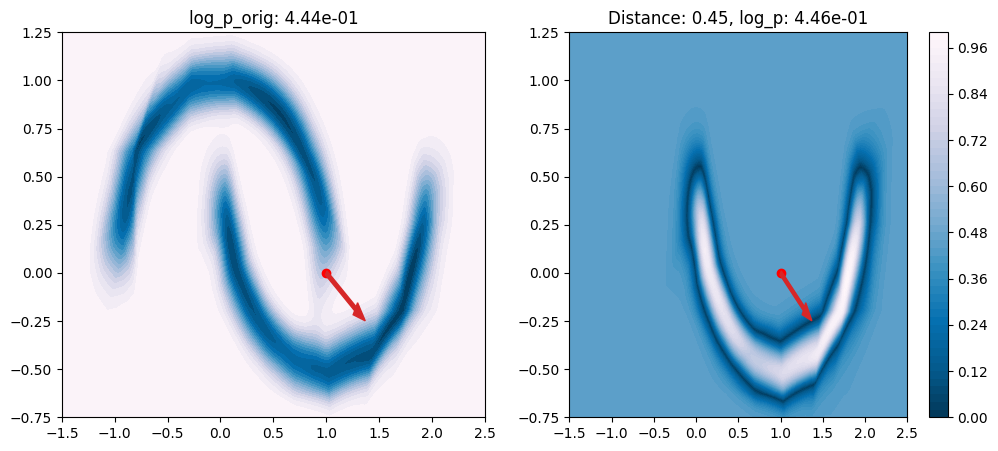

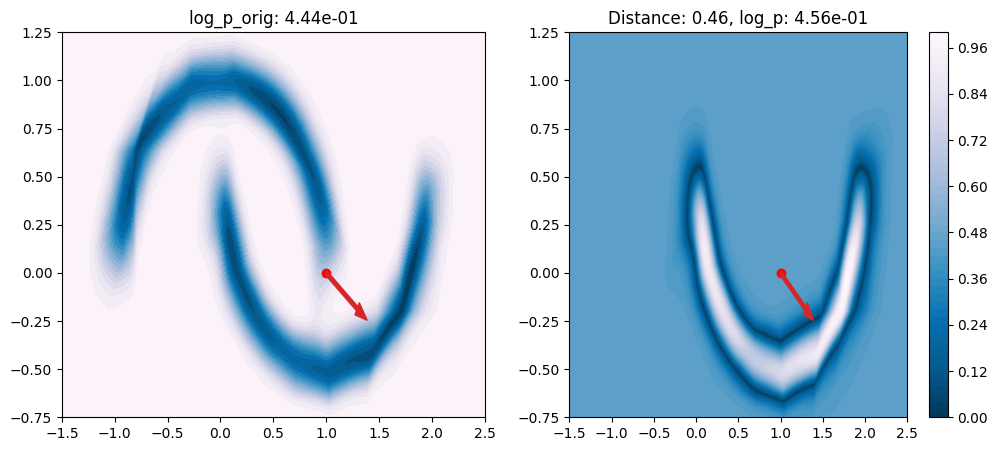

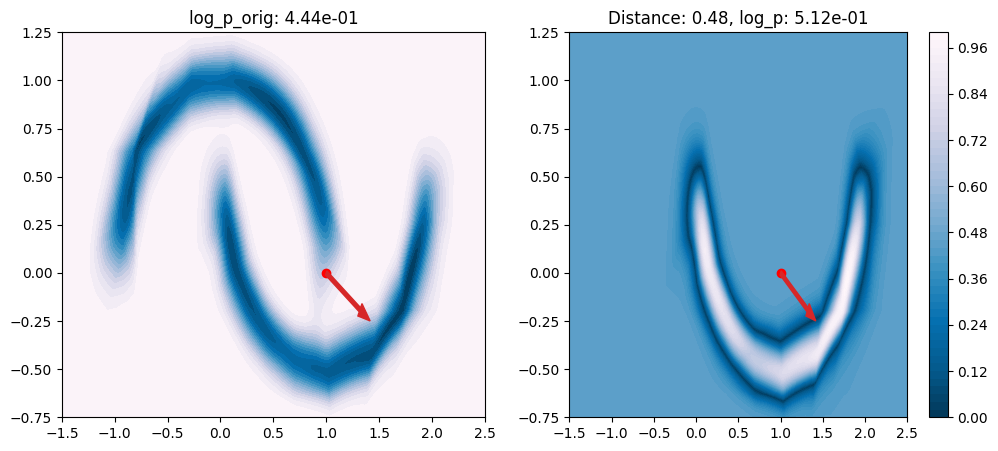

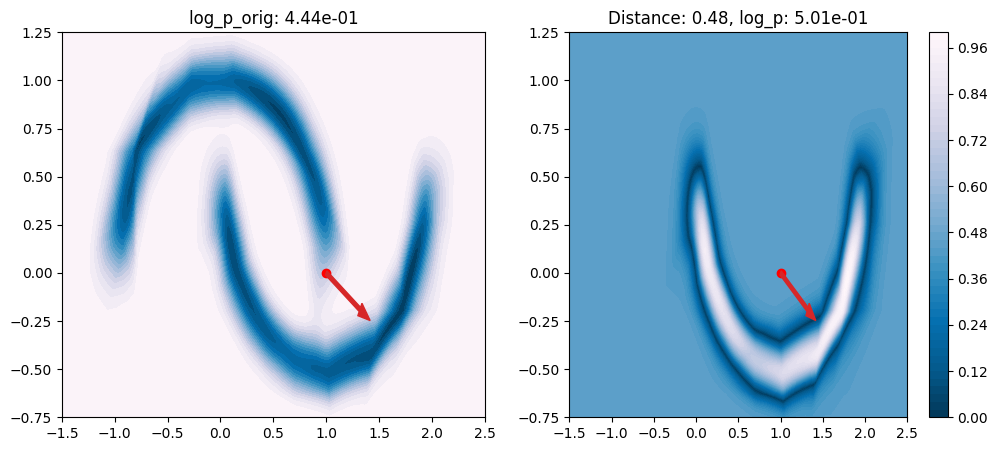

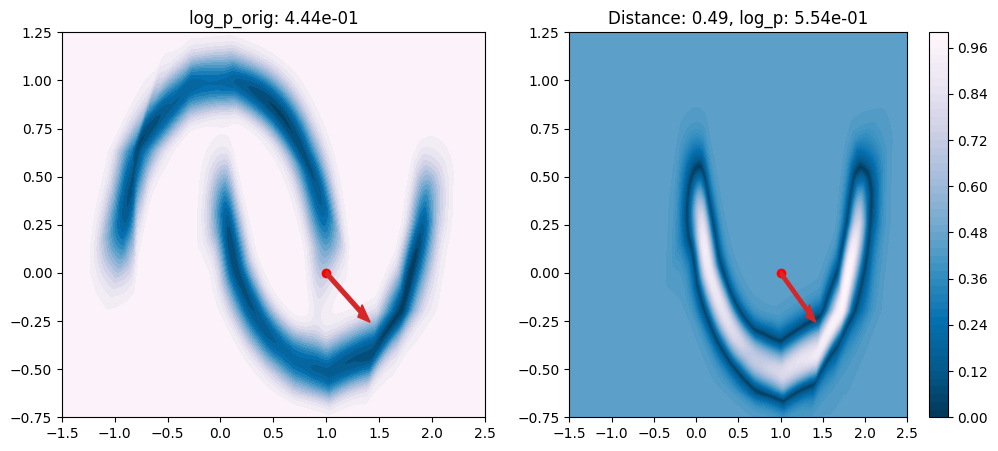

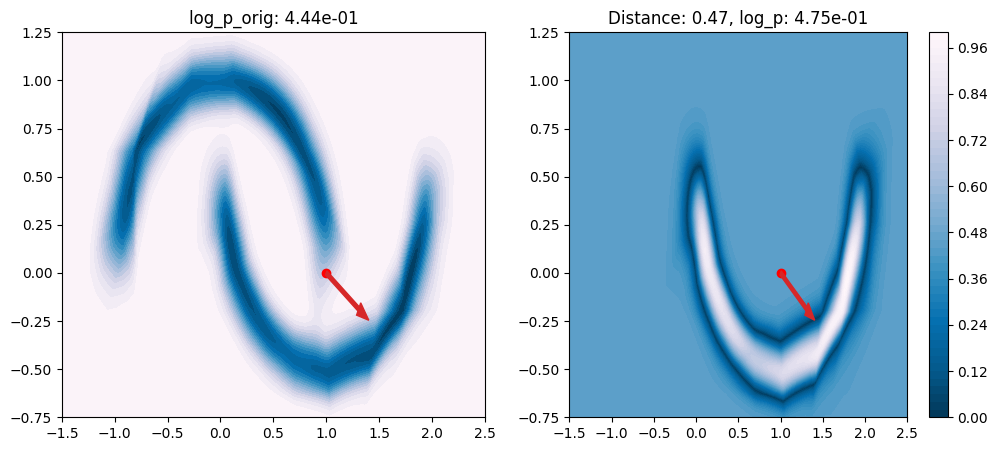

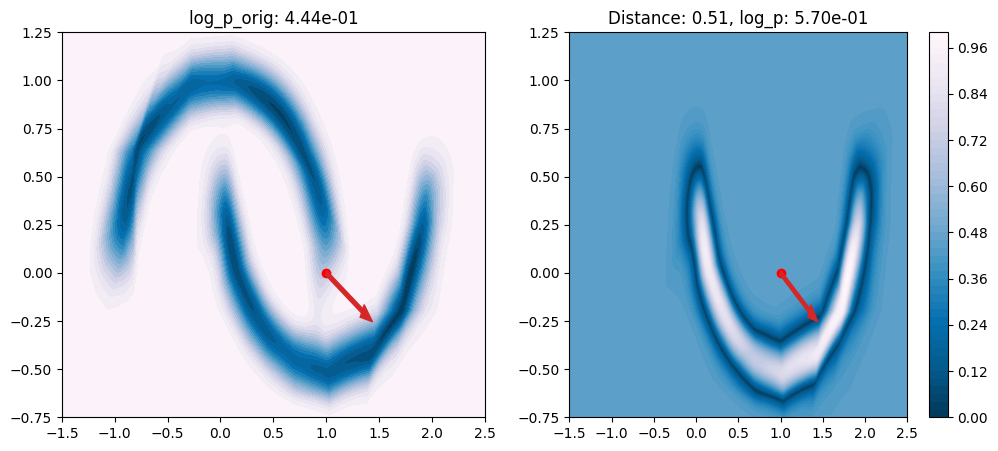

In [11]:
optimizer = Adam([x], lr=0.1)
alpha = 0.001

num_iterations = 100
for i in range(num_iterations):
    y = optim_function(x, x_origin, flow, alpha=alpha)
    optimizer.zero_grad()
    y.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        plot_distributions(x, x_origin, flow, optim_function, alpha=alpha)